In [15]:
#Import Packages

import numpy as np
from numpy import random as rd
from pykrx import stock
import scipy as sp
import pandas as pd
from scipy import optimize
import copy
import matplotlib.pyplot as plt

In [278]:
class Optima:
    def __init__(self):
        self.var_cov_mat = None
        self.rf = 0.015
        self.ret = None
        self.tickers = None
        self.data_start = None
        self.data_end = None
        self.N = None
        self.data = None
        
        self.tp = None # time Point
        self.windowLength = None
        
    def setTickers(self, tickers):
        self.tickers = tickers
        self.N = len(self.tickers)
    
    def setDataDate(self, srt, end):
        if type(srt) == str:
            self.data_start = srt
        else:
            self.data_start = str(srt)
        if type(end) == str:
            self.data_end = end
        else:
            self.data_end = str(end)
        
    def loadData(self):
        raw_data = []
        N = self.N
        for i in range(N):
            raw_data.append(stock.get_market_ohlcv_by_date(self.data_start, self.data_end, self.tickers[i])["종가"])
        self.data = pd.DataFrame(np.asarray(raw_data).T, columns = self.tickers, dtype=np.int32)
        self.ret = pd.DataFrame(np.nan, index=np.arange(self.data.shape[0]), columns=self.data.columns)
        for i in range(1, self.data.shape[0]):
            self.ret.iloc[i] = self.data.iloc[i]/self.data.iloc[i-1]
        self.var_cov_mat = np.identity(self.N)
    
    def gen_var_cov_mat(self):
        ret_tp = self.ret.iloc[self.tp - self.windowLength : self.tp]
        for i in range(0, self.N):
            for j in range(0, self.N):
                #print('-',end=' ')
                #print(np.cov(ret_tp.iloc[1:,i], ret_tp.iloc[1:,j])[0,1])
                self.var_cov_mat[i][j] = np.cov(ret_tp.iloc[1:,i], ret_tp.iloc[1:,j])[0,1]
    
    def setWindowLength(self, time):
        self.windowLength = time
    
    def setTimePoint(self, tp):
        self.tp = tp
        
    
    def eq_constraint(self, w):
        summation = 0
        for i in w:
            summation += i
            
        return summation - 1
    
    def flarray(self, w): #수익률도 전체 데이터가 아닌 특정기간의 수익률로 바꿔줘야함!!!!!
        ret_exd = np.cumprod(self.ret.iloc[self.tp - self.windowLength : self.tp]) - self.rf
        return -(np.dot(np.transpose(ret_exd.iloc[-1]), w) / (np.dot(np.dot(np.transpose(w), self.var_cov_mat), w))**(1/2))

    def Max_Sharp(self):
        return sp.optimize.fmin_slsqp(self.flarray, [1/self.N for i in range(self.N)], bounds=[(0,1) for i in range(self.N)], eqcons=[self.eq_constraint])
    
    
    def w(self):
        self.gen_var_cov_mat()
        return self.Max_Sharp()
    
    
    
    

In [442]:
optima = Optima()
tickers = ["002810", "003920", "004380", "011280"]#, "016580", "007340", "000370", "001510", "033270", "004710", "001500"]

optima.setTickers(tickers)
optima.setDataDate(20180101, 20191231)

optima.loadData()

optima.setWindowLength(30)
optima.setTimePoint(145)
optima.w()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -156.971630902948
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7


array([0.34638894, 0.43800272, 0.09406473, 0.12154362])

In [280]:
optima.setWindowLength(29)
optima.w()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -157.7021752684225
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 7


array([0.33260327, 0.45340114, 0.09811513, 0.11588047])

In [41]:
rebal = pd.DataFrame(([1+np.random.randint(-10,11)*0.001 for i in range(5)] for i in range(33333)))

In [383]:
cumprod_DF

,0,1,2,3,4
0,4,-5,0,3,-3
1,12,-9,1,-8,8
2,9,6,4,8,-4
3,-5,-7,10,-2,12
4,9,10,-9,-6,3
5,-4,6,-2,4,-6
6,8,4,-4,-5,-5
7,10,0,-5,10,10
8,0,8,-6,-7,-1
9,-1,2,8,6,4


In [384]:
cumprod_DF.append(rebal.iloc[1*5 :(2)*5])

,0,1,2,3,4
0,4,-5,0,3,-3
1,12,-9,1,-8,8
2,9,6,4,8,-4
3,-5,-7,10,-2,12
4,9,10,-9,-6,3
5,-4,6,-2,4,-6
6,8,4,-4,-5,-5
7,10,0,-5,10,10
8,0,8,-6,-7,-1
9,-1,2,8,6,4


In [42]:
fr = 60
scalar = pd.DataFrame(index=range(0,rebal.shape[0]//fr+1))
scalar['k'] = 1

cumprod_DF = copy.deepcopy(rebal)

for i in range((rebal.shape[0]//fr)):#fr = 4 , range(0,2)
    cumprod_DF.iloc[i*fr:(i+1)*fr] = rebal.iloc[i*fr :(i+1)*fr].cumprod()
    if i != 0:
        #이것도 실제로는 동일비중이 아니라, 특정 w벡터로 나눠줘야함.
        scalar['k'].iloc[i] = cumprod_DF.iloc[i*fr - 1].sum()/cumprod_DF.shape[1]

if rebal.shape[0]%fr != 0:
    mok = rebal.shape[0]//fr
    scalar['k'].iloc[-1 ] = cumprod_DF.iloc[(mok)*fr -1 ].sum()/cumprod_DF.shape[1]
    cumprod_DF.iloc[mok*fr : ] = rebal.iloc[mok*fr:].cumprod()

cumprod_DF#.head(33)

,0,1,2,3,4
0,1.004000,1.007000,1.000000,0.997000,1.007000
1,0.995968,1.010021,1.003000,0.993012,1.010021
2,0.991984,1.018101,1.001997,0.995991,1.009011
3,0.987024,1.007920,1.002999,0.994995,1.014056
4,0.979128,0.999857,1.008014,0.996985,1.013042
...,...,...,...,...,...
33328,0.966041,0.971914,1.003426,1.018779,1.000574
33329,0.967007,0.980661,1.010450,1.027948,0.990568
33330,0.975710,0.985564,1.016513,1.019724,0.993540
33331,0.975710,0.977680,1.026678,1.027882,0.992546


In [30]:
scalar#.cumprod()

,k
0,1.000000
1,1.011462
2,1.003936
3,1.016452
4,1.021603
...,...
162,0.979738
163,0.997238
164,0.994840
165,1.029976


In [232]:
#scalar의 마지막 값.
cumprod_DF.iloc[(mok)*fr -1 ].sum()/cumprod_DF.shape[1]

0.9958174294990091

In [318]:
scalar.cumprod().iloc[1][0]

1.0012439990189999

In [44]:
scalars = pd.DataFrame(index=range(0,rebal.shape[0]), columns=range(0,rebal.shape[1]))
for i in range(rebal.shape[0]//fr):
    scalars[0].iloc[i*fr : i*fr+fr] = scalar.cumprod().iloc[i][0]#float(scalar.iloc[i]) * float(scalar.iloc[i-1])
    if i == 0:
        scalars[0].iloc[i*fr : i*fr+fr] = 1
#for i in range(6):#rebal.shape[1]):
#    scalars[i].iloc[i:i+fr] = 3#scalar.iloc[i]

if rebal.shape[0]%fr != 0:#32개 중 마지막 2개에 대 한 처리
    mok = rebal.shape[0]//fr
    scalars[0].iloc[(mok)*fr : ] = scalar.cumprod().iloc[-1][0]#float(scalar.iloc[-1])*float(scalar.iloc[-2])

for i in range(1,rebal.shape[1]):
    scalars[i] = scalars[i-1]
scalars.head(32)

,0,1,2,3,4
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,1,1,1
8,1,1,1,1,1
9,1,1,1,1,1


In [266]:
scalars[0].cumprod()

0            1
1            1
2            1
3            1
4            1
        ...   
305    8.48003
306    8.49204
307    8.50406
308     8.5161
309    8.52815
Name: 0, Length: 310, dtype: object

In [45]:
ww=pd.DataFrame(([1/rebal.shape[1] for i in range(rebal.shape[1])] for i in range(rebal.shape[0])))
ww

,0,1,2,3,4
0,0.2,0.2,0.2,0.2,0.2
1,0.2,0.2,0.2,0.2,0.2
2,0.2,0.2,0.2,0.2,0.2
3,0.2,0.2,0.2,0.2,0.2
4,0.2,0.2,0.2,0.2,0.2
...,...,...,...,...,...
33328,0.2,0.2,0.2,0.2,0.2
33329,0.2,0.2,0.2,0.2,0.2
33330,0.2,0.2,0.2,0.2,0.2
33331,0.2,0.2,0.2,0.2,0.2


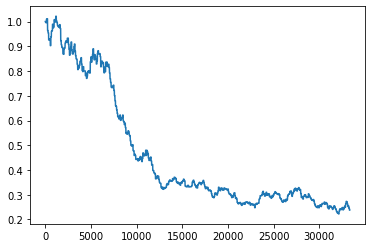

In [46]:
plt.figure()
plt.plot(scalars[0])
plt.show()

In [53]:
#scalar = scalar.cumprod() 이렇게하면 안되고, frequency마다 그전 거랑 곱해줘야됨.
for i in

In [144]:
cumprod_DF.sum(axis=1)/6 #실제로는 6으로 나누는 대신 w벡터들을 곱해줌.

0      1.000833
1      1.001013
2      1.004339
3      1.005358
4      1.005674
         ...   
995    1.005869
996    1.006330
997    1.008606
998    1.009436
999    1.010177
Length: 1000, dtype: float64

In [ ]:
########w_vectors ????? w * cumret * k = portfolio returns

In [16]:
cumprod_DF.iloc[7].sum()

6.029899468999999

array([1.])

In [267]:
testdf.iloc[1].sum()/6

1.0200000000000002

In [186]:
pd.DataFrame(w)

NameError: name 'w' is not defined

In [42]:
asdfasdf = pd.DataFrame(([3,3,3,'r'],[3,3,3,3]))
asdfasdff = pd.DataFrame(([4,4,4,4],[4,4,4,4,]))
asdfasdf*asdfasdff

,0,1,2,3
0,12,12,12,rrrr
1,12,12,12,12


In [166]:
scalar.iloc[400]

k    1.054182
Name: 400, dtype: float64

In [334]:
cumprod_DF

,0,1,2,3,4,5
0,0.996000,0.995000,1.000000,1.007000,1.004000,1.001000
1,1.003968,1.004950,1.007000,0.997937,1.012032,1.008007
2,1.004972,1.009975,0.996930,1.006918,1.018104,1.014055
3,1.005977,1.017045,0.998924,1.007925,1.007923,1.014055
4,1.000947,1.024164,0.998924,1.005910,1.000868,1.014055
...,...,...,...,...,...,...
328,0.999000,0.993000,1.004000,1.008000,1.005000,0.999000
329,0.993000,1.000000,0.998000,1.002000,1.011000,1.011000
330,0.993000,1.001000,0.990000,0.997000,0.999000,1.003000
331,1.005000,1.005000,0.991000,1.011000,1.001000,0.991000


In [174]:
scalar[598:603]

,k
598,1.054182
599,1.054182
600,1.141145
601,1.141145
602,1.141145


In [188]:
(ww * cumprod_DF * scalars).sum(axis=1)[590:610]

Series([], dtype: float64)

In [30]:
scalars.iloc[179:181]

,0,1,2,3,4,5
179,1.12327,1.12327,1.12327,1.12327,1.12327,1.12327
180,1.11164,1.11164,1.11164,1.11164,1.11164,1.11164


In [289]:
(ww * cumprod_DF * scalars).sum(axis=1)[248:253]

248    1.093506
249    1.097050
250    1.055928
251    1.053143
252    1.053274
dtype: float64

In [293]:
rebal.cumprod()[248:253]

,0,1,2,3,4,5
248,0.929599,0.988311,1.112685,1.087620,1.265333,1.140513
249,0.933317,0.993253,1.113798,1.099583,1.275456,1.129108
250,0.936117,1.004178,1.113798,1.094085,1.262701,1.141528
251,0.932372,1.009199,1.118253,1.084239,1.251337,1.138104
252,0.931440,1.003144,1.122726,1.080986,1.263850,1.134689


In [291]:
rebal[248:253]

,0,1,2,3,4,5
248,1.002,1.011,1.003,1.001,1.007,1.001
249,1.004,1.005,1.001,1.011,1.008,0.990
250,1.003,1.011,1.000,0.995,0.990,1.011
251,0.996,1.005,1.004,0.991,0.991,0.997
252,0.999,0.994,1.004,0.997,1.010,0.997


In [290]:
cumprod_DF[248:253]

,0,1,2,3,4,5
248,1.004104,1.065149,1.086286,1.047073,1.035793,1.001044
249,1.008120,1.070474,1.087372,1.058591,1.044080,0.991034
250,1.003000,1.011000,1.000000,0.995000,0.990000,1.011000
251,0.998988,1.016055,1.004000,0.986045,0.981090,1.007967
252,0.997989,1.009959,1.008016,0.983087,0.990901,1.004943


In [62]:
scalar[19:23]

,k
19,1.000000
20,0.989824
21,0.979752
22,0.969782


In [359]:
cumprod_DF

,0,1,2,3,4
0,1.003000,1.004000,1.000000,0.992000,1.010000
1,1.001997,1.008016,1.006000,0.994976,0.999900
2,1.005003,1.006000,1.002982,0.991991,0.992901
3,1.016058,1.016060,0.996964,0.997943,0.993894
4,1.022154,1.008948,0.988988,0.990957,0.983955
...,...,...,...,...,...
328,0.998000,1.001000,0.997000,0.993000,1.002000
329,1.009000,1.009000,1.010000,1.008000,0.990000
330,0.990000,0.996000,0.990000,0.998000,0.998000
331,0.995000,0.993000,1.007000,1.003000,1.000000


In [366]:
scalars.iloc[300:]

,0,1,2,3,4
300,1.10807,1.10807,1.10807,1.10807,1.10807
301,1.10807,1.10807,1.10807,1.10807,1.10807
302,1.10807,1.10807,1.10807,1.10807,1.10807
303,1.10807,1.10807,1.10807,1.10807,1.10807
304,1.10807,1.10807,1.10807,1.10807,1.10807
305,1.10807,1.10807,1.10807,1.10807,1.10807
306,1.10807,1.10807,1.10807,1.10807,1.10807
307,1.10807,1.10807,1.10807,1.10807,1.10807
308,1.10807,1.10807,1.10807,1.10807,1.10807
309,1.10807,1.10807,1.10807,1.10807,1.10807


In [430]:
(ww * cumprod_DF * scalars).sum(axis=1).iloc[-1]

4.9807235967387635

In [434]:
rebal.cumprod().sum(axis=1).iloc[-1]/6

4.909872591776103

In [103]:
mdd = pd.DataFrame(([rd.randint(-5, 8)*0.01 + 1 for i in range(100)]))
#mdd = pd.DataFrame([1,2,3,4,2,3,4,5,1,2,6])
mdd = mdd.cumprod()

In [104]:
newhigh = copy.deepcopy(mdd)
for i in range(1, mddcum.shape[0]):
    newhigh.iloc[i] = max(mdd.iloc[i][0], mdd.iloc[0:i].max()[0])

In [98]:
mdd.iloc[0:3].max()[0]

3

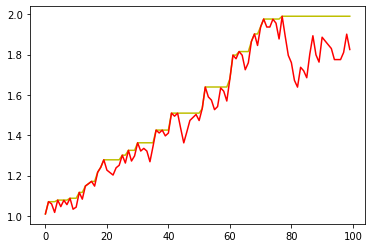

In [105]:
plt.figure()
plt.plot(newhigh, c='y')
plt.plot(mdd, c='r')
plt.show()

In [108]:
maxdrawdown = - newhigh + mdd

0   -0.351401
dtype: float64


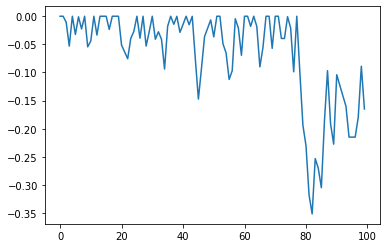

In [111]:
plt.plot(maxdrawdown)
print(maxdrawdown.min())

In [492]:
scalars

,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
484,0.924381,0.924381,0.924381,0.924381
485,0.924381,0.924381,0.924381,0.924381
486,0.924381,0.924381,0.924381,0.924381
487,0.924381,0.924381,0.924381,0.924381


In [480]:
cumprod_DF

,0,1,2,3
1,0.967015,0.995733,1.161215,0.998012
2,0.964246,0.992888,1.133178,0.994036
3,0.950462,0.984353,1.144860,0.998012
4,0.934031,0.974395,1.088785,0.994036
5,0.939508,0.970128,1.119159,0.990060
...,...,...,...,...
485,1.034576,1.005917,1.008772,0.969484
486,1.043994,1.031953,0.995614,0.962441
487,1.047155,1.024852,1.008772,1.007042
488,1.057034,1.020118,1.026316,1.022300


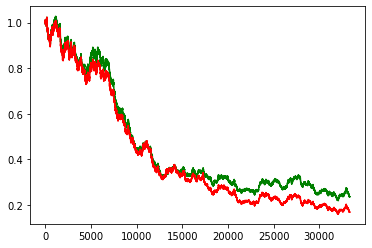

In [112]:
(ww * cumprod_DF * scalars).sum(axis=1)
import matplotlib.pyplot as plt
plt.figure()
plt.plot((ww * cumprod_DF * scalars).sum(axis=1), c='g')
#plt.plot((ww*cumprod_DF).sum(axis=1))
#리밸런싱을 안하면 cumprod_DF를 쓰는게 아니라 그냥 cumprod(testdf)하면 되는 거였음.
plt.plot(rebal.cumprod().sum(axis=1)/rebal.shape[1], c='r')
plt.show()

In [489]:
rebal.cumprod().sum/4

,002810,003920,004380,011280
1,0.241754,0.248933,0.290304,0.249503
2,0.241062,0.248222,0.283294,0.248509
3,0.237615,0.246088,0.286215,0.249503
4,0.233508,0.243599,0.272196,0.248509
5,0.234877,0.242532,0.279790,0.247515
...,...,...,...,...
485,0.241677,0.151138,0.134346,0.410537
486,0.243877,0.155050,0.132593,0.407555
487,0.244615,0.153983,0.134346,0.426441
488,0.246923,0.153272,0.136682,0.432903


In [485]:
(ww * cumprod_DF * scalars)

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,0.241754,0.248933,0.290304,0.249503
2,0.241062,0.248222,0.283294,0.248509
3,0.237615,0.246088,0.286215,0.249503
4,0.233508,0.243599,0.272196,0.248509
...,...,...,...,...
485,0.239086,0.232463,0.233122,0.224043
486,0.241262,0.238479,0.230082,0.222416
487,0.241993,0.236839,0.233122,0.232723
488,0.244276,0.235745,0.237177,0.236249


In [198]:
testdf.cumprod().sum(axis=1)/6

,0,1,2,3,4,5,yes
0,0.997,0.996,1.010,0.992,0.998,1.000,605.293
1,0.996,1.006,1.010,1.005,0.998,1.007,608.222
2,0.990,1.002,1.000,1.001,0.997,1.008,605.798
3,0.997,0.999,0.995,0.997,1.007,1.006,606.101
4,0.990,1.009,0.996,1.004,1.000,1.006,606.505
...,...,...,...,...,...,...,...
95,0.996,1.003,0.990,0.992,0.995,0.996,603.172
96,0.996,0.999,0.997,0.991,1.004,0.992,603.879
97,1.002,1.009,1.001,1.008,0.994,1.005,607.919
98,1.000,1.001,1.009,1.008,0.995,0.990,606.303


In [210]:
aaaa.sum(axis=1)

0    6
1    9
2    7
dtype: int64

In [ ]:
asdfasdf

In [227]:
(testdf * ww).sum(axis=1)

0    1.174
1    1.224
2    1.136
3    1.196
4    1.268
5    1.214
6    1.170
7    1.208
8    1.244
9    1.190
dtype: float64

In [199]:
testdf

,0,1,2,3,4,5
0,0.98,0.90,1.05,0.98,0.95,1.01
1,0.97,1.08,0.99,0.95,1.11,1.02
2,0.98,0.91,0.95,0.96,0.96,0.92
3,0.96,1.00,0.95,0.98,1.02,1.07
4,1.09,1.05,1.06,1.10,1.05,0.99
5,1.05,1.03,0.96,1.05,0.90,1.08
6,1.11,1.08,0.94,0.90,0.90,0.92
7,1.07,1.03,0.92,0.98,1.10,0.94
8,1.02,1.01,1.09,1.09,1.00,1.01
9,0.98,0.90,1.09,0.99,1.00,0.99


In [124]:
testdf#.cumprod()

,0,1,2,3,4,5
0,1.00,0.94,0.94,1.02,0.94,1.05
1,1.02,1.02,1.02,1.04,1.07,0.97
2,1.08,0.99,0.96,1.03,1.02,1.05
3,1.09,0.91,1.01,0.94,0.95,0.96
4,1.05,0.97,0.92,0.99,1.09,1.04
5,1.11,1.05,0.93,1.02,1.00,1.09
6,0.92,1.03,1.11,1.04,1.09,1.07
7,1.05,1.05,0.91,1.09,1.08,0.93
8,0.90,1.07,0.91,0.91,1.09,0.93
9,0.97,1.10,1.00,0.94,0.97,1.11


In [79]:
cumprod_DF

""


# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#

In [39]:
testdf.iloc[0:2].sum(axis = 1)

0    6.03
1    6.11
dtype: float64

In [222]:
freq = 10
w = [1/5, 1/5, 1/5, 1/5, 1/5]

In [239]:
rebal.shape[0]%freq

8

In [243]:
a = np.asarray([1,2,3])
b = np.asarray([1,2,3])
a*b

array([1, 4, 9])

In [242]:
for i in range((rebal.shape[0]//freq)):
    df = rebal.iloc[i*freq :(i+1)*freq]
    print(df)
    
if rebal.shape[0]%freq != 0:
    print(rebal.iloc[-(rebal.shape[0]%freq):])


      0     1     2     3     4     5
0  1.02  0.93  0.95  0.99  1.02  0.95
1  1.05  0.94  1.05  1.11  1.11  1.03
2  0.97  1.05  0.98  1.02  0.99  1.04
3  0.90  0.99  1.09  1.11  1.08  0.97
4  0.96  1.03  0.97  1.01  0.99  1.10
5  0.95  1.08  0.94  0.90  0.90  1.00
6  0.92  1.07  0.97  1.08  1.06  0.99
7  0.99  1.09  1.10  1.07  0.94  1.11
8  0.99  1.01  1.07  0.97  0.98  0.97
9  1.01  1.03  1.08  1.06  1.04  0.97
       0     1     2     3     4     5
10  1.09  0.93  1.03  1.07  1.01  0.94
11  0.97  1.04  1.02  0.91  0.91  1.04
12  0.93  1.09  0.93  0.91  0.97  1.00
13  1.04  0.97  1.00  1.06  1.03  1.05
14  1.01  0.90  0.98  1.01  1.02  0.91
15  0.99  0.90  1.05  1.08  1.01  1.08
16  1.04  0.91  1.04  0.98  0.96  0.93
17  1.00  1.07  1.10  0.93  0.96  0.94
18  1.11  1.10  0.97  0.98  0.92  0.91
19  1.06  1.02  0.92  1.03  1.07  1.09
       0     1     2     3     4     5
20  0.93  0.98  1.00  1.01  1.07  0.90
21  1.11  0.95  1.08  0.95  1.11  0.94
22  0.93  0.95  0.96  0.98  1.00  1.

In [120]:
rebal.iloc[5:10].cumprod()

,0,1,2,3,4,5
5,1.060000,1.100000,0.910000,1.04000,0.960000,1.000000
6,1.134200,1.133000,0.819000,0.98800,0.892800,0.940000
7,1.100174,1.178320,0.794430,1.07692,0.964224,0.921200
8,1.045165,1.225453,0.714987,1.07692,0.896728,0.985684
9,1.076520,1.127417,0.779336,1.07692,0.941565,0.965970


In [119]:
rebal.iloc[1:5].cumprod()

,0,1,2,3,4,5
1,1.070000,0.900000,0.900000,1.020000,1.030000,0.900000
2,0.984400,0.882000,0.810000,0.948600,0.999100,0.819000
3,1.092684,0.943740,0.801900,1.033974,1.059046,0.761670
4,1.212879,0.972052,0.745767,0.982275,1.016684,0.845454


In [121]:
rebal.head(11)

,0,1,2,3,4,5
0,1.00,0.94,0.94,1.02,0.94,1.05
1,1.02,1.02,1.02,1.04,1.07,0.97
2,1.08,0.99,0.96,1.03,1.02,1.05
3,1.09,0.91,1.01,0.94,0.95,0.96
4,1.05,0.97,0.92,0.99,1.09,1.04
5,1.11,1.05,0.93,1.02,1.00,1.09
6,0.92,1.03,1.11,1.04,1.09,1.07
7,1.05,1.05,0.91,1.09,1.08,0.93
8,0.90,1.07,0.91,0.91,1.09,0.93
9,0.97,1.10,1.00,0.94,0.97,1.11


In [34]:
pd.DataFrame.cumsum(rebal.cumprod().iloc[-1])[-1:]/5

5    1.617605
Name: 111, dtype: float64

In [134]:
rebal.cumprod().iloc[-1]

0    3.541576
1    0.591426
2    0.583374
3    1.051113
4    4.484368
5    1.611752
Name: 99, dtype: float64

In [205]:
aaaa = pd.DataFrame(([1,2,3],[2,2,5],[3,2,2]))

In [206]:
aaaa

,0,1,2
0,1,2,3
1,2,2,5
2,3,2,2


In [207]:
aaaa.cumprod()

,0,1,2
0,1,2,3
1,2,4,15
2,6,8,30


In [208]:
aaaa.cumprod().sum(axis=1)

0     6
1    21
2    44
dtype: int64

In [211]:
aaaa.sum(axis=1)

0    6
1    9
2    7
dtype: int64